<a href="https://colab.research.google.com/github/mansi0411/Intelligent-Document-Automation-Smart-OCR-Bot/blob/main/Intelligent_Document_Automation_Smart_OCR_Bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("urbikn/sroie-datasetv2")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'sroie-datasetv2' dataset.
Path to dataset files: /kaggle/input/sroie-datasetv2


In [ ]:
!ls /root/.cache/kagglehub/datasets/urbikn/sroie-datasetv2/versions/4/SROIE2019/train/img


X00016469612.jpg  X51005719856.jpg  X51006466055.jpg  X51007339097.jpg
X00016469619.jpg  X51005719862.jpg  X51006466056.jpg  X51007339098.jpg
X00016469620.jpg  X51005719864.jpg  X51006466060.jpg  X51007339100.jpg
X00016469622.jpg  X51005719873.jpg  X51006466062.jpg  X51007339106.jpg
X00016469623.jpg  X51005719874.jpg  X51006466065.jpg  X51007339107.jpg
X00016469669.jpg  X51005719882.jpg  X51006466066.jpg  X51007339110.jpg
X00016469672.jpg  X51005719883.jpg  X51006466778.jpg  X51007339111.jpg
X00016469676.jpg  X51005719886.jpg  X51006502529.jpg  X51007339112.jpg
X51005200938.jpg  X51005719893.jpg  X51006502531.jpg  X51007339113.jpg
X51005230617.jpg  X51005719896.jpg  X51006502533.jpg  X51007339114.jpg
X51005255805.jpg  X51005719899.jpg  X51006554833.jpg  X51007339115.jpg
X51005268200.jpg  X51005719902.jpg  X51006555072.jpg  X51007339117.jpg
X51005268262.jpg  X51005719904.jpg  X51006555125.jpg  X51007339118.jpg
X51005268400.jpg  X51005719906.jpg  X51006555570.jpg  X51007339120.jpg
X51005

In [ ]:
! pip install opencv-python matplotlib numpy

In [ ]:
import os
one_image_path=os.path.join(path,'SROIE2019','train','img','X00016469612.jpg')

In [ ]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

def display_image(image, title="Image"):
    plt.figure(figsize=(7, 7))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

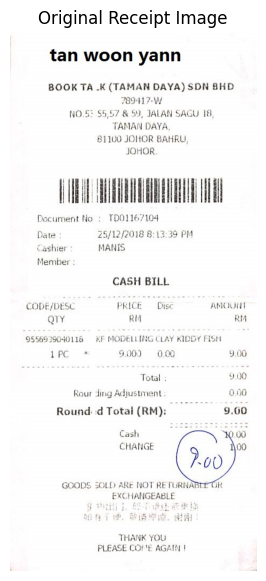

In [ ]:
one_image = cv2.imread(one_image_path)
display_image(one_image, "Original Receipt Image")

In [ ]:
# Convert the image to grayscale
def convert_to_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

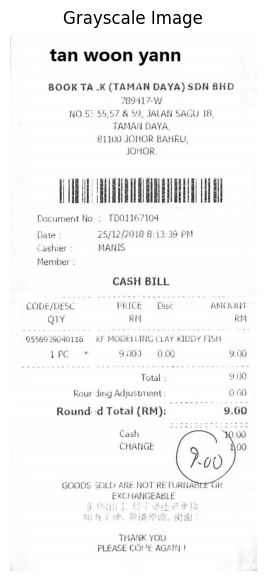

In [ ]:
grayscale_image = convert_to_grayscale(one_image)
display_image(grayscale_image, "Grayscale Image")

In [ ]:
def reduce_noise(gray_image):
  return cv2.GaussianBlur(gray_image, (5, 5), 0)

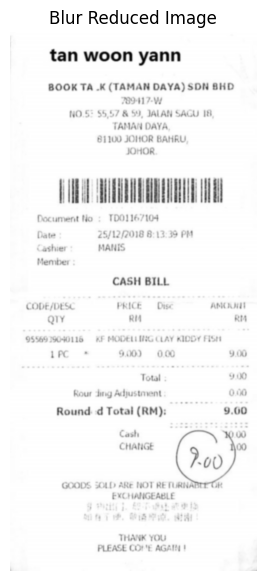

In [ ]:
blur_reduced_image = reduce_noise(grayscale_image)
display_image(blur_reduced_image, "Blur Reduced Image")

In [ ]:
def binarize_image(blur_reduced_image):
  return cv2.adaptiveThreshold(
    blur_reduced_image,
    255,
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    cv2.THRESH_BINARY_INV, # Invert the colors (text becomes white)
    11, # Block size
    4  # Constant C
  )

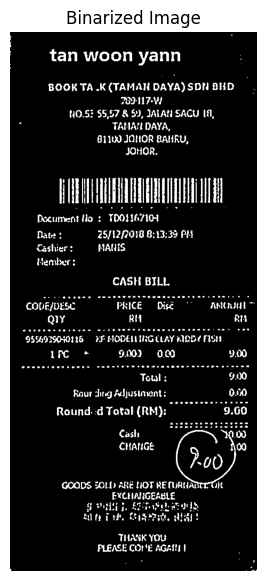

In [ ]:
binarized_image = binarize_image(blur_reduced_image)
display_image(binarized_image, "Binarized Image")

In [ ]:
def deskew_image(image):
    """
    Corrects the skew of an image by finding the minimum area rectangle
    of the text block and rotating accordingly.
    """
    # Find all non-zero (white) pixels
    coords = cv2.findNonZero(image)

    # Get the minimum area bounding rectangle
    # It returns (center(x,y), (width, height), angle of rotation)
    rect = cv2.minAreaRect(coords)
    angle = rect[-1] - 90

    # The `cv2.minAreaRect` angle has a specific range.
    # We need to adjust it for our rotation.
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = angle

    # Get the rotation matrix and rotate the image
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h),
                             flags=cv2.INTER_CUBIC,
                             borderMode=cv2.BORDER_REPLICATE)
    print(f"Detected skew angle: {angle:.2f} degrees")

    # Now, rotate the original grayscale image by the same angle
    (h, w) = rotated.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    deskewed_gray = cv2.warpAffine(rotated, M, (w, h),
                                  flags=cv2.INTER_CUBIC,
                                  borderMode=cv2.BORDER_REPLICATE)

    return deskewed_gray

In [ ]:
deskewed_image = deskew_image(binarized_image)

Detected skew angle: 0.00 degrees


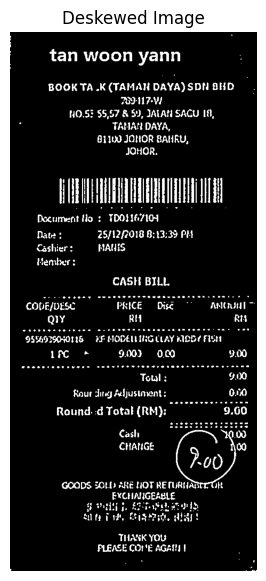

In [ ]:
display_image(deskewed_image, "Deskewed Image")

In [ ]:
def process_one_image(image):
  image = convert_to_grayscale(image)
  print("Converted image to grayscale..")
  image = reduce_noise(image)
  print("Reduced noise in the image..")
  image = binarize_image(image)
  print("Binarized the image..")
  image = deskew_image(image)
  print("Corrected image orientation..")
  return image

In [ ]:
import time
output_folder_path = "/content/processed_images"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")


for image_name in os.listdir(os.path.join(path, 'SROIE2019', 'train', 'img'))[:20]:
  print(f"Processing image: {image_name}")
  image_path = os.path.join(path, 'SROIE2019', 'train', 'img', image_name)
  image = cv2.imread(image_path)
  processed_image = process_one_image(image)
  # save image
  output_path = os.path.join(output_folder_path, image_name)
  cv2.imwrite(output_path, processed_image)
  print(f"Saved processed image to: {output_path}")
  print("-"*50)

print("Processing images is completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Processing image: X51007231344.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -0.45 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51007231344.jpg
--------------------------------------------------
Processing image: X51005442344.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: -1.10 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51005442344.jpg
--------------------------------------------------
Processing image: X51008142030.jpg
Converted image to grayscale..
Reduced noise in the image..
Binarized the image..
Detected skew angle: 0.00 degrees
Corrected image orientation..
Saved processed image to: /content/processed_images/X51008142030.jpg
--------------------------------------------------
Processing image: X51005447853.jpg
Converted image to grayscale..
Reduced noise in the image..


In [ ]:
! pip install pytesseract pillow

In [ ]:
from PIL import Image
import pytesseract

pytesseract.image_to_string(Image.open('/content/processed_images/X51005361897.jpg'))

'a a a a cr ne\n\n| nal Pare rand i Pinte |\n\nRCE Tat eyAD}\nNORCENT UW Leen en CECE\nSELANGOR DARULEHSAN\n+ TEL:03-3271 9872 FAX: 03-3271:9481\nexis Bh oan (alee che MRI -s1-)\n\n \n\n \n\nrts\n\nReceipt No. CS1801/26821 Date: 17/01/2018\n\nITEM ~=.QTY UP DISC% ara\n\nCac TETL Te RKO AE an\n~ LION FILE 220*307 LAMINATING. FILM\n\nBrother <0.\n\n| SUB-TOTAL (EX) ; PACKS\nTOTAL TAX oS\nROUNDING mK\nTOTAL. VRS)\neste aes EX ars. he\nans ar. nea\n\n \n\nca ; op POE e TAX.\ncena 7c) Oe)\ncSt 6.00 26.00 smste}\nTOTAL: 26.00 4,56\n\nNote: (*) Indicated The item Sold Has Been Related\nTo GST (Goods & Services Tax).\n\nGOODS SOLD.ARE NOT RETURNABLE,\n\ninl ele\n\n \n\x0c'

In [ ]:
from PIL import Image
import pytesseract
import time

input_folder_path = "/content/processed_images"
output_folder_path = "/content/tesseract_output"
start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(input_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print("Extracting text from image..")
  text = pytesseract.image_to_string(Image.open(image_path))
  output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".txt"))
  with open(output_path, "w") as f:
    f.write(text)

  print(f"Saved extracted text to {output_path}")
  print("-"*50)

print("Text Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: X51006556815.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51006556815.txt
--------------------------------------------------
Processing image 2/20: X51005361897.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005361897.txt
--------------------------------------------------
Processing image 3/20: X51005711442.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005711442.txt
--------------------------------------------------
Processing image 4/20: X51005447853.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51005447853.txt
--------------------------------------------------
Processing image 5/20: X51006620189.jpg
Extracting text from image..
Saved extracted text to /content/tesseract_output/X51006620189.txt
--------------------------------------------------
Processing image 6/20: X51005441408.jp

In [ ]:
prompt = """
Extract the information from the given image.
Information to be extracted: company, date, address, total.
The image has been converted to grayscale, noise reduced, binarized, and deskewed using opencv.
Always give your response in the following format:
{
    "company": "COMPANY_NAME",
    "date": "DATE",
    "address": "ADDRESS",
    "total": "TOTAL",
}
Also, the text has been extracted from the image using tesseract.
Use the extracted text as support for extracting information.
If you believe the extraction is incorrect somewhere, you may correct it yourself and provide corrected information.
Respond with the extracted information only in the specified format.
Here is the text:


"""

In [ ]:
from google import genai
from google.colab import userdata # colab only code
from PIL import Image
import json
import time

In [ ]:
genai_client = genai.Client(api_key=userdata.get('project_key'))

In [ ]:
image_folder_path = "/content/processed_images"
text_folder_path = "/content/tesseract_output"
output_folder_path = "/content/json_output"

start_time = time.time()

if os.makedirs(output_folder_path, exist_ok=True):
  print(f"Created folder: {output_folder_path}")

total_images = sum(1 for entry in os.scandir(image_folder_path))
print(f"Total images in folder: {total_images}")

for i, image_name in enumerate(os.listdir(input_folder_path)[:20], 1):
  print(f"Processing image {i}/{total_images}: {image_name}")
  image_path = os.path.join(input_folder_path, image_name)
  print(f"Loading image: {image_path}")
  with open(image_path, "rb") as f:
    image = Image.open(image_path)


  text_path = os.path.join(text_folder_path, image_name.replace(".jpg", ".txt"))
  print(f"Loading extracted text: {text_path}")
  with open(text_path, "r") as f:
    text = f.read()

  print("Extracting information from image and text..")

  prompt = prompt + text



  contents = [
        image,
        {
            "text": prompt
        }
    ]
  response = genai_client.models.generate_content(model='gemini-2.5-flash', contents=contents)

  # Access the usage_metadata attribute
  usage_metadata = response.usage_metadata

  # Print the different token counts
  print(f"Input Token Count: {usage_metadata.prompt_token_count}")
  print(f"Thoughts Token Count: {response.usage_metadata.thoughts_token_count}")
  print(f"Output Token Count: {usage_metadata.candidates_token_count}")
  print(f"Total Token Count: {usage_metadata.total_token_count}")

  extracted_information = json.loads(response.text.replace('```json', '').replace('```', ''))
  output_path = os.path.join(output_folder_path, image_name.replace(".jpg", ".json"))
  with open(output_path, "w") as f:
    json.dump(extracted_information, f, indent=4)

  print(f"Saved extracted information to {output_path}")
  print("-"*50)
  time.sleep(60)

print("Information Extraction Completed.")
print(f"Total time taken: {time.time() - start_time} seconds")

Total images in folder: 20
Processing image 1/20: X51006556815.jpg
Loading image: /content/processed_images/X51006556815.jpg
Loading extracted text: /content/tesseract_output/X51006556815.txt
Extracting information from image and text..
Input Token Count: 832
Thoughts Token Count: 208
Output Token Count: 88
Total Token Count: 1128
Saved extracted information to /content/json_output/X51006556815.json
--------------------------------------------------
Processing image 2/20: X51005361897.jpg
Loading image: /content/processed_images/X51005361897.jpg
Loading extracted text: /content/tesseract_output/X51005361897.txt
Extracting information from image and text..
Input Token Count: 1119
Thoughts Token Count: 236
Output Token Count: 92
Total Token Count: 1447
Saved extracted information to /content/json_output/X51005361897.json
--------------------------------------------------
Processing image 3/20: X51005711442.jpg
Loading image: /content/processed_images/X51005711442.jpg
Loading extracted te